In [2]:
import json
import os

import albumentations as A
import cv2
import numpy as np
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def iou(box1, box2):
    """IoU 계산 함수"""
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    return interArea / float(box1Area + box2Area - interArea)

In [4]:
def read_data_from_json_by_columns(filename):
    data = {}
    for key in filename:
        if type(filename[key]) == list:
            data[key] = pd.DataFrame(filename[key])
        else:
            data[key] = pd.DataFrame([filename[key]])
    return data

In [5]:
def load_json_data():
    with open('../dataset/train.json') as t:
        train_data = json.loads(t.read())
    with open('../dataset/val_split.json') as t:
        val_data = json.loads(t.read())
    with open('../dataset/test.json') as t:
        test_data = json.loads(t.read())
    test = read_data_from_json_by_columns(test_data)
    val = read_data_from_json_by_columns(val_data)
    train = read_data_from_json_by_columns(train_data)
    train['images']['annotation_num'] = train['annotations']['image_id'].value_counts()
    val['images']['annotation_num'] = val['annotations']['image_id'].value_counts()

    return test,val,  train, test_data, val_data, train_data


def csv_to_dataframe(dir, csv_file):
    file_path = os.path.join(dir, csv_file)  # 파일 경로 생성
    df = pd.read_csv(file_path)  # csv 파일을 DataFrame으로 불러오기
    df['image_id'] = df['image_id'].str.extract(r"(\d+)").astype(int)
    annotation = []
    ann_id = 0
    
    # 각 파일의 내용 처리
    for row in df.itertuples(index=False, name=None):
        img = row[1]  # image_id
        pred_str = row[0]  # PredictionString

        # PredictionString이 NaN일 경우 스킵
        if pd.isna(pred_str):
            continue
        
        pred = list(map(float, pred_str.split()))
        
        # 예측값을 6개씩 묶어서 처리
        for j in range(0, len(pred), 6):
            if j + 5 >= len(pred):  # 인덱스 범위 체크
                continue
            
            category_id = int(pred[j])
            confidence = pred[j + 1]
            bbox = (pred[j + 2], pred[j + 3], pred[j + 4]-pred[j + 2], pred[j + 5]-pred[j + 3])  # (x, y, w, h)
            area = pred[j + 4] * pred[j + 5]  # 넓이 계산 (w * h)

            # annotation 리스트에 추가
            annotation.append({
                "image_id": img,
                "category_id": category_id,
                "area": area,
                "bbox": [pred[j + 2], pred[j + 3], pred[j + 4], pred[j + 5]],  # COCO 포맷으로 변경
                "isclowd": 0,
                "id": ann_id,
                "confidence": confidence
            })
            
            ann_id += 1
    
    anno = pd.DataFrame(annotation)
    
    return anno


def coco_to_voc(coco_bbox):
    """
    Convert COCO bounding box format to Pascal VOC format.

    Parameters:
    coco_bbox (list of floats): COCO bbox [x_min, y_min, width, height]

    Returns:
    list of floats: Pascal VOC bbox [x_min, y_min, x_max, y_max]
    """
    x_min, y_min, width, height = coco_bbox
    x_max = x_min + width
    y_max = y_min + height
    return [x_min, y_min, x_max, y_max]

In [14]:
def evaluate_predictions(bbox_prediction, gt_df, iou_threshold=0.5):
    """
    예측 박스와 실제 박스를 비교하여 TP, FP, FN 계산.
    """
    tp = []
    fp = []
    fn = []

    # 모든 실제 박스에 대해 IoU 계산
    for idx_gt, gt in gt_df.iterrows():
        gt_box = gt['bbox']
        best_iou = 0
        best_pred = None

        for idx_pred, pred in bbox_prediction.iterrows():
            pred_box = pred['bbox']
            iou_value = iou(gt_box, pred_box)

            if iou_value > best_iou:
                best_iou = iou_value
                best_pred = idx_pred

        # IoU가 기준치 이상일 경우 매칭 처리
        if best_iou >= iou_threshold:
            tp.append((gt['image_id'], idx_gt, best_pred, best_iou))
        else:
            fn.append((gt['image_id'], idx_gt))

    # 매칭되지 않은 예측 박스를 False Positive로 처리
    for idx_pred, pred in bbox_prediction.iterrows():
        if idx_pred not in [item[2] for item in tp]:
            fp.append((pred['image_id'], idx_pred))

    return tp, fp, fn

In [6]:
def draw_bbox(image_path, bbox, color='red'):
    # 이미지 로드
    image = Image.open(image_path)
    plt.figure()
    plt.imshow(image)
    ax = plt.gca()
    
    # matplotlib rectangle 생성 및 추가
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    
    plt.show()

In [7]:
test, val, train, test_data, val_data, train_data = load_json_data()
dir = 'valid'
choose_csv = 'co_dino_5scale_r50_lsj_8xb2_1x_coco.csv'
bbox_prediction = csv_to_dataframe(dir,choose_csv)

In [8]:
print(bbox_prediction.head())
#print(train['annotations'])

   image_id  category_id           area  \
0      1149            1   50496.331957   
1      1149            7  812205.125000   
2      1149            7   32399.413990   
3      1149            7   74263.805690   
4      1149            7   70197.963503   

                                                bbox  isclowd  id  confidence  
0  [342.8173522949219, 61.15715408325195, 392.437...        0   0    0.832823  
1  [167.82858276367188, 360.24969482421875, 793.1...        0   1    0.110140  
2  [365.6261901855469, 41.36286926269531, 395.595...        0   2    0.093604  
3  [205.99795532226562, 184.37374877929688, 291.0...        0   3    0.082686  
4  [341.77197265625, 40.843994140625, 529.6159057...        0   4    0.080763  


In [9]:
# 예측 박스의 중심 좌표 계산 (COCO 포맷)
pred_centers = np.array([
    [(row['bbox'][0] + row['bbox'][2] / 2), (row['bbox'][1] + row['bbox'][3] / 2)]  # COCO 포맷으로 변경
    for _, row in bbox_prediction.iterrows()
])

print(pred_centers)

from scipy.spatial import KDTree
# KDTree 생성
tree = KDTree(pred_centers)

iou_threshold = 0.5  # 매칭 기준 IoU
tp = []  # True Positives (TP)
fp = []  # False Positives (FP)
fn = []  # False Negatives (FN)
matched_pred = set()  # 매칭된 예측 인덱스 저장

[[ 539.036026    125.49396133]
 [ 564.41311646  872.24969482]
 [ 563.42399597   82.31303787]
 ...
 [ 429.82756042 1487.47137451]
 [ 812.3678894  1112.35467529]
 [ 288.58537292  785.09353638]]


In [10]:
gt_df = val['annotations']

# Ground Truth에 대해 KDTree로 가까운 예측 박스 선택 및 매칭
for idx_gt, gt in gt_df.iterrows():
    gt_box = gt['bbox']  # COCO 포맷 bbox 사용
    gt_center = [(gt_box[0] + gt_box[2]) / 2, (gt_box[1] + gt_box[3]) / 2]

    # 근처의 예측 박스 인덱스 검색 (반경 50 내)
    nearby_pred_indices = tree.query_ball_point(gt_center, r=50)

    best_iou = 0
    best_pred = None

    # 가까운 예측 박스에 대해서만 IoU 계산
    for idx_pred in nearby_pred_indices:
        if idx_pred in matched_pred:
            continue  # 이미 매칭된 예측은 건너뜀

        pred = bbox_prediction.iloc[idx_pred]
        pred_box = pred['bbox']
        iou_value = iou(gt_box, pred_box)

        if iou_value > best_iou:
            best_iou = iou_value
            best_pred = idx_pred

    # IoU가 기준치 이상일 경우 매칭 처리
    if best_iou >= iou_threshold:
        matched_pred.add(best_pred)
        tp.append((gt['image_id'], idx_gt, best_pred, best_iou))  # TP 기록
    else:
        fn.append((gt['image_id'], idx_gt))  # FN 기록

# 매칭되지 않은 예측 박스를 False Positive로 처리
for idx_pred, pred in bbox_prediction.iterrows():
    if idx_pred not in matched_pred:
        fp.append((pred['image_id'], idx_pred))

In [15]:
# 예측 결과 평가
tp, fp, fn = evaluate_predictions(bbox_prediction, val['annotations'], iou_threshold=0.5)

In [ ]:
# 결과 출력
print(f"True Positives (TP): {len(tp)}, Details: {tp}")
print("hi")
print(f"False Positives (FP): {len(fp)}, Details: {fp}")
print(f"False Negatives (FN): {len(fn)}, Details: {fn}")

True Positives (TP): 408, Details: [(4098, 1, 181877, 0.8954669740882761), (2052, 23, 43689, 0.663259962258916), (8, 27, 200641, 0.9203796364559144), (8, 29, 80351, 0.8052718204608709), (8, 30, 6883, 0.8879655920788194), (8, 31, 41067, 0.866547110356526), (8, 32, 183017, 0.9950736346253753), (8, 33, 225238, 0.8991276013975609), (4106, 39, 187314, 0.6362129492650107), (4113, 48, 235804, 0.5330468357316865), (17, 49, 108094, 0.5284016756550437), (19, 52, 228078, 0.9820184283259935), (19, 53, 80863, 0.8475998848919386), (19, 54, 224359, 0.9557139350302304), (19, 59, 85555, 0.5165311092867544), (4119, 62, 214999, 0.7062159742164122), (26, 107, 206174, 0.5000988818413389), (29, 112, 260079, 0.9556029850785254), (2078, 114, 202564, 0.5271944479424749), (4133, 126, 123248, 0.6853026842988751), (43, 132, 14216, 0.7504075535091069), (2099, 158, 212863, 0.945993831329548), (2101, 169, 86734, 0.5278968362788873), (4159, 205, 44604, 0.7317438379608932), (4161, 206, 1704, 0.9859316627623055), (4161

../dataset/train/1149.jpg
True
(1024, 1024, 3)


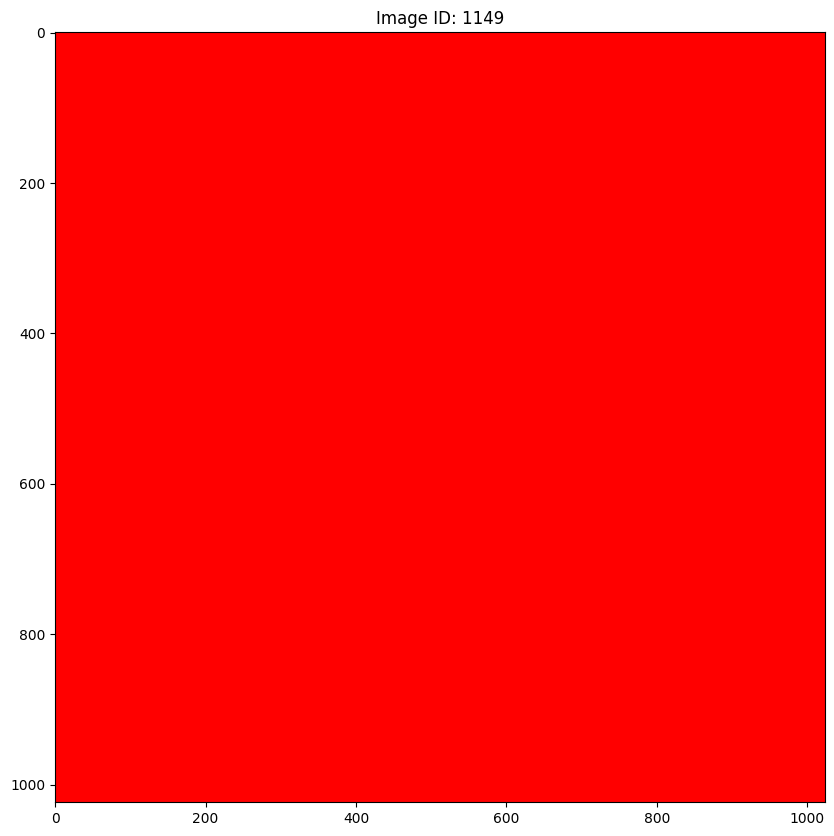

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import cv2

#for image_id in val['images']['id'].unique():
# # 이미지 경로 가져오기
#    image_path = os.path.join('../dataset/', val['images'][val['images']['id'] == image_id]['file_name'].iloc[0])
#    print(image_path)
#    print(os.path.exists(image_path))

# 시각화할 이미지 ID 선택
image_id = 1149  # 예시로 1149를 선택

# 이미지 경로 가져오기
image_path = os.path.join('../dataset/', val['images'][val['images']['id'] == image_id]['file_name'].iloc[0])
print(image_path)
print(os.path.exists(image_path))


    # 이미지 경로가 올바른지 확인하고 이미지 로드
if os.path.exists(image_path):
    try:
        # OpenCV를 사용하여 이미지 로드 (색상 이미지로 읽기)
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        # 이미지 로드 확인
        if image is not None:
            print(image.shape)  # 이미지 크기 확인
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            ax = plt.gca()
            # Ground Truth 박스 그리기
            gt_boxes = val['annotations'][val['annotations']['image_id'] == image_id]['bbox'].values
            for i, gt_box in enumerate(gt_boxes):
                rect = patches.Rectangle(
                    (gt_box[0], gt_box[1]),
                    gt_box[2] - gt_box[0],
                    gt_box[3] - gt_box[1],
                    linewidth=2,
                    edgecolor='green',
                    facecolor='none',
                )
                ax.add_patch(rect)

            # 예측 박스 그리기
            # TP는 파란색, FP는 빨간색, FN은 노란색으로 표시
            for _, _, idx_pred, _ in tp:
                pred = bbox_prediction[bbox_prediction.index == idx_pred]
                pred_box = pred['bbox'].iloc[0]
                rect = patches.Rectangle(
                    (pred_box[0], pred_box[1]),
                    pred_box[2] - pred_box[0],
                    pred_box[3] - pred_box[1],
                    linewidth=2,
                    edgecolor='blue',
                    facecolor='none',
                )
                ax.add_patch(rect)
        
            for _, idx_pred in fp:
                pred = bbox_prediction[bbox_prediction.index == idx_pred]
                pred_box = pred['bbox'].iloc[0]
                rect = patches.Rectangle(
                    (pred_box[0], pred_box[1]),
                    pred_box[2] - pred_box[0],
                    pred_box[3] - pred_box[1],
                    linewidth=2,
                    edgecolor='red',
                    facecolor='none',
                )
                ax.add_patch(rect)
        
            for _, idx_gt in fn:
                gt = val['annotations'][val['annotations'].index == idx_gt]
                gt_box = gt['bbox'].iloc[0]
                rect = patches.Rectangle(
                    (gt_box[0], gt_box[1]),
                    gt_box[2] - gt_box[0],
                    gt_box[3] - gt_box[1],
                    linewidth=2,
                    edgecolor='yellow',
                    facecolor='none',
                )
                ax.add_patch(rect)
        
            plt.title(f"Image ID: {image_id}")
            plt.show()
        else:
            print(f"이미지 파일을 읽을 수 없습니다: {image_path}")
    except Exception as e:
        print(f"이미지 로드 중 오류 발생: {type(e)} {e}")
else:
    print(f"이미지 파일을 찾을 수 없습니다.: {image_path}")